<a href="https://colab.research.google.com/github/hscrown/madatpublicdata/blob/main/collaborative_filtering_refactor(9)_%EC%9E%A0%EC%9E%AC%EC%9A%94%EC%9D%B8%EA%B8%B0%EB%B0%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

잠재요인기반 협업 필터링  

# 필요한 데이터 임포트

In [160]:
# !pip install datasets

from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")
# from datasets import load_dataset

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [161]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds

def load_and_preprocess(data_path):
    # CSV 파일을 읽어와 DataFrame을 반환
    df = pd.read_csv(data_path)
    # 필요한 데이터 클린징이나 전처리 작업을 추가
    return df

def create_user_item_matrix(df, user_id_col, item_id_col, rating_col):
    # 피벗 테이블을 생성하여 사용자-장소 평점 행렬을 만듦
    user_item_matrix = df.pivot_table(index=user_id_col, columns=item_id_col, values=rating_col)
    # NaN 값은 0으로 채움
    user_item_matrix = user_item_matrix.fillna(0)
    return user_item_matrix

def perform_svd(user_item_matrix, num_components=1):
    # 사용자 평균 평점을 계산
    user_ratings_mean = np.mean(user_item_matrix, axis=1)
    # 평균을 빼서 행렬을 정규화
    matrix_normalized = user_item_matrix.sub(user_ratings_mean, axis=0).values
    # SVD 수행
    U, sigma, Vt = svds(matrix_normalized, k=num_components)
    sigma = np.diag(sigma)  # 시그마를 대각 행렬로 변환
    return U, sigma, Vt, user_ratings_mean

def recommend_places(user_id, df_svd_preds, user_ratings, num_recommendations=5):
    user_id = int(user_id)  # 'User Id'를 정수로 처리

    # 사용자 ID 존재 여부 확인
    if user_id not in df_svd_preds.index:
        print(f"No data available for User ID {user_id}.")
        return pd.DataFrame()  # 빈 DataFrame 반환

    user_rated_places = user_ratings[user_ratings['User Id'] == user_id]['Place Id'].unique()
    user_predictions = df_svd_preds.loc[user_id].drop(user_rated_places)
    top_n_places = user_predictions.sort_values(ascending=False).head(num_recommendations)

    recommended_places = user_ratings[user_ratings['Place Id'].isin(top_n_places.index)]
    recommended_places = recommended_places.drop_duplicates(subset=['Place Id'])
    recommended_places['Predicted Rating'] = top_n_places.values
    return recommended_places[['Place Id', 'Predicted Rating']]


# 함수사용

In [162]:

# 데이터 로드 및 전처리
data_path = 'user_rating_240429.csv'
df = load_and_preprocess(data_path)
user_item_matrix = create_user_item_matrix(df, 'User Id', 'Place Id', 'Rating')
U, sigma, Vt, user_ratings_mean = perform_svd(user_item_matrix, num_components=12)

# 예측 평점 계산 및 DataFrame 생성
predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.values.reshape(-1, 1)
predicted_ratings = np.clip(predicted_ratings, 1, 5)  # 평점을 1에서 5 사이로 제한
df_svd_preds = pd.DataFrame(predicted_ratings, index=user_item_matrix.index, columns=user_item_matrix.columns)

# 사용자 ID 설정 및 추천 실행
user_id = 55
recommended_places = recommend_places(user_id, df_svd_preds, df, num_recommendations=5)
print(recommended_places)

      Place Id  Predicted Rating
1695       117               1.0
1727       115               1.0
2639       116               1.0
3162         0               1.0
4143       123               1.0


In [163]:
# 실제평점과 예측평점비교

# 사용자 77의 실제 평점 데이터 가져오기
actual_ratings = df[df['User Id'] == 77]

# 사용자 77의 예측 평점 가져오기
predicted_ratings_for_user = df_svd_preds.loc[77]

# 실제 평점 데이터와 예측 평점 데이터를 Place Id를 기준으로 결합
comparison_df = actual_ratings.merge(predicted_ratings_for_user.rename('Predicted Rating'), left_on='Place Id', right_index=True)

# 필요한 컬럼 선택
comparison_df = comparison_df[['Place Id', 'Rating', 'Predicted Rating']]

# 결과 출력
print(comparison_df)




      Place Id  Rating  Predicted Rating
1225       132       5               5.0
3835        25       5               1.0
3887        87       5               1.0


In [164]:
# 실제 평점이 0이 아닌 데이터 필터링
non_zero_ratings = df[df['Rating'] > 0]

# 모든 사용자의 예측 평점과 실제 평점을 비교하기 위해 합치기
# 예측 평점 DataFrame을 재구성하여 각 사용자의 예측 평점을 long format으로 변환
predicted_ratings_long = df_svd_preds.stack().reset_index()
predicted_ratings_long.columns = ['User Id', 'Place Id', 'Predicted Rating']

# 실제 평점과 예측 평점 결합
comparison_df = non_zero_ratings.merge(predicted_ratings_long, on=['User Id', 'Place Id'])

# 결과 출력
print(comparison_df[['User Id', 'Place Id', 'Rating', 'Predicted Rating']])




      User Id  Place Id  Rating  Predicted Rating
0        1685        34       1               1.0
1        1166        34       5               1.0
2         936        34       3               1.0
3          82        34       4               1.0
4         757        34       1               1.0
...       ...       ...     ...               ...
4470      482       159       1               1.0
4471      717       159       5               1.0
4472      785       159       5               1.0
4473     2978       159       1               1.0
4474      272       159       5               1.0

[4475 rows x 4 columns]


<Axes: ylabel='Frequency'>

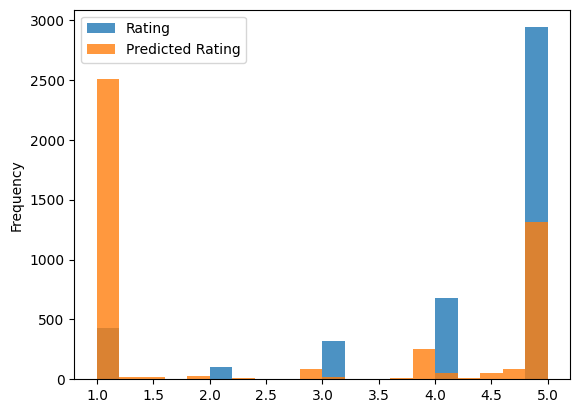

In [165]:
# 시각화
# 필요한 컬럼 선택
view_df = comparison_df[['Rating', 'Predicted Rating']]
view_df

# 히스토그램
view_df.plot(kind='hist', bins=20, alpha=.8)


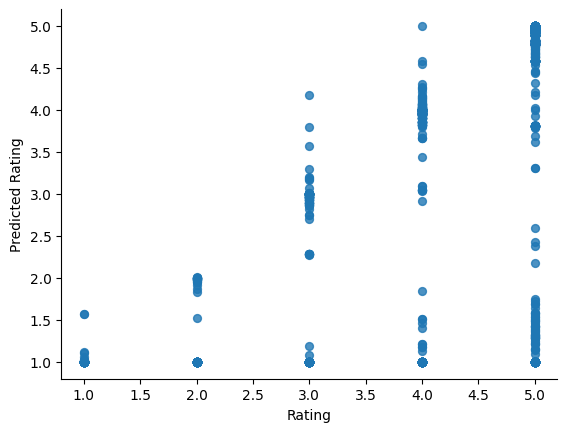

In [166]:
view_df.plot(kind='scatter', x='Rating', y='Predicted Rating', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [167]:
# 성능함수
# RMSE
def rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted) ** 2))

# MAE
def mae(actual, predicted):
    return np.mean(np.abs(actual - predicted))

# 함수 수행
rmse_value = rmse(comparison_df['Rating'], comparison_df['Predicted Rating'])
mae_value = mae(comparison_df['Rating'], comparison_df['Predicted Rating'])

print("RMSE:", rmse_value)
print("MAE:", mae_value)



RMSE: 2.476720431527707
MAE: 1.698449897079726
